In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as stats

import numpyro
import numpyro.distributions as dist

from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM
from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class Simulation(Baseline):
    LINK = HBM

    def __init__(self, config: Config, mu_a_delta: int, sigma_a_delta: int):
        super(Simulation, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.mu_a_delta = mu_a_delta
        self.sigma_a_delta = sigma_a_delta

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
                sigma_a_delta = numpyro.deterministic("sigma_a_delta", self.sigma_a_delta)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )



In [3]:
class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [4]:
class NonHierarchicalBayesianModel(Baseline):
    LINK = "non_hierarchical_bayesian"

    def __init__(self, config: Config):
        super(NonHierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        # global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        # global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        # global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        # global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        # global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        # global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                # """ Hyper-priors """
                # mu_a_baseline = numpyro.sample(
                #     "mu_a_baseline",
                #     dist.TruncatedNormal(50, 50, low=0)
                # )
                # sigma_a_baseline = numpyro.sample(
                #     "sigma_a_baseline",
                #     dist.HalfNormal(50)
                # )

                # sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                # sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                # sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                # sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                # sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                # sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(50, 100, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(100))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(100))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(50))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(500))

                    sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(100))
                    sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(100))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                # mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                # sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(0, 100))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [5]:
mu_a_delta = -1.5
sigma_a_delta = 1

toml_path = "/home/vishu/repos/hbmep-paper/configs/human/tms/mixed-effects.toml"
CONFIG = Config(toml_path=toml_path)

MODEL = Simulation(config=CONFIG, mu_a_delta=mu_a_delta, sigma_a_delta=sigma_a_delta)

src = "/home/vishu/data/hbmep-processed/human/tms/data.csv"
DF = pd.read_csv(src)

DF[MODEL.features[0]] = 0
DF[MODEL.response] = DF[MODEL.response] * 1000

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)

2023-10-05 15:09:36,457 - hbmep.config - INFO - Verifying configuration ...
2023-10-05 15:09:36,457 - hbmep.config - INFO - Success!
2023-10-05 15:09:36,527 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-10-05 15:09:36,539 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-10-05 15:09:36,539 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-10-05 15:09:36,540 - hbmep.dataset.core - INFO - Processing data ...
2023-10-05 15:09:36,541 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
prefix = "hbm-vs-nhbm"
prefix_2 = f"mu_a_delta_{mu_a_delta}_sigma_a_delta_{sigma_a_delta}"

priors = {
    site.a, "a_baseline",
    site.b, "b_baseline",
    site.v, "v_baseline",
    site.L, "L_baseline",
    site.H, "H_baseline",
    site.g_1, "g_1_baseline",
    site.g_2, "g_2_baseline",
    site.mu, site.beta
}

POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in priors}

""" Experiment """
TOTAL_SUBJECTS = 200

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 100], columns=[MODEL.intensity]),
        how="cross"
    )
PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num_points=60)

POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)
OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])

N_space = [2, 4, 6, 8, 12, 16, 20]
# N_space = [2, 4, 6, 8, 10, 12]

keys = jax.random.split(MODEL.rng_key, num=2)

n_draws = 50
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, CONFIG.MCMC_PARAMS["num_chains"] * CONFIG.MCMC_PARAMS["num_samples"], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 50
repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()



2023-10-05 15:09:36,604 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-10-05 15:10:12,271 - hbmep.utils.utils - INFO - func:predict took: 35.67 sec


In [25]:
N_counter, draw_counter, repeat_counter = 2, 0, 0

N = N_space[N_counter]
draw_ind = draws_space[draw_counter]
seed = repeats_space[repeat_counter]

N_dir, draw_dir, seed_dir = f"N_{N}", f"draw_{draw_ind}", f"seed_{seed}"

subjects_ind = \
    jax.random.choice(
        key=jax.random.PRNGKey(seed),
        a=np.arange(0, TOTAL_SUBJECTS, 1),
        shape=(N,),
        replace=False
    ) \
    .tolist()

ind = PREDICTION_DF[MODEL.subject].isin(subjects_ind)
PREDICTION_DF[MODEL.response] = OBS[draw_ind, ...]
df = PREDICTION_DF[ind].reset_index(drop=True).copy()
# df[MODEL.response] = OBS[draw_ind, ...][ind, ...]

""" Build model """
config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, "test")
model = HierarchicalBayesianModel(config=config)

""" Load data """
df, _ = model.load(df=df)

""" Fit """
_, posterior_samples = model.run_inference(df=df)

""" Predict """
prediction_df = model.make_prediction_dataset(df=df, num_points=1000)
ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

""" Plot """
model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)


2023-10-05 15:23:19,297 - hbmep.config - INFO - Verifying configuration ...
2023-10-05 15:23:19,298 - hbmep.config - INFO - Success!
2023-10-05 15:23:19,298 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-10-05 15:23:19,299 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/test
2023-10-05 15:23:19,299 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/test
2023-10-05 15:23:19,300 - hbmep.dataset.core - INFO - Processing data ...
2023-10-05 15:23:19,301 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-10-05 15:23:19,301 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-05 15:23:54,806 - hbmep.utils.utils - INFO - func:run_inference took: 35.50 sec
2023-10-05 15:23:54,812 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-10-05 15:24:12,789 - hbmep.utils.utils - INFO - func:predict took: 17.98 sec
2023-10-05 15:24:12,839 - hbmep.model.baseline - INFO - Rendering ...
2023-10-05 15:24:15,485 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/test/recruitment_curves.pdf
2023-10-05 15:24:15,486 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.69 sec
2023-10-05 15:24:15,582 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-05 15:24:23,512 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/test/posterior_predictive_check.pdf
2023-10-05 15:24:23,514 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 8.03 sec
2023-10-05 15:24:23,514 - hbmep.utils.utils

(-5.5, 100.0)

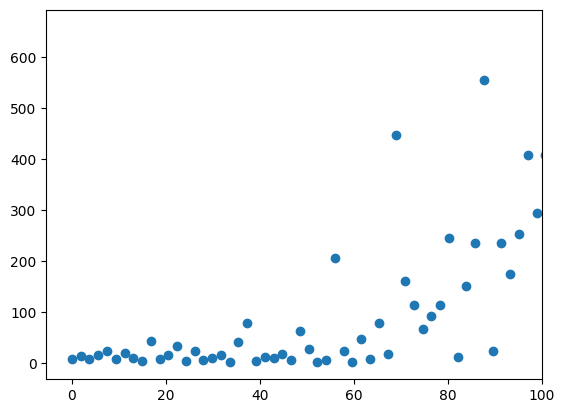

In [52]:
ind = df[MODEL.combination_columns].apply(tuple, axis=1).isin([(0, 4)])

plt.scatter(data=df[ind], x=MODEL.intensity, y=MODEL.response[0])
plt.xlim(right=100)

In [30]:
a_pred = posterior_samples[site.a]
a_pred.shape

(4000, 6, 2, 1)

In [31]:
a.shape

(4000, 200, 2, 1)

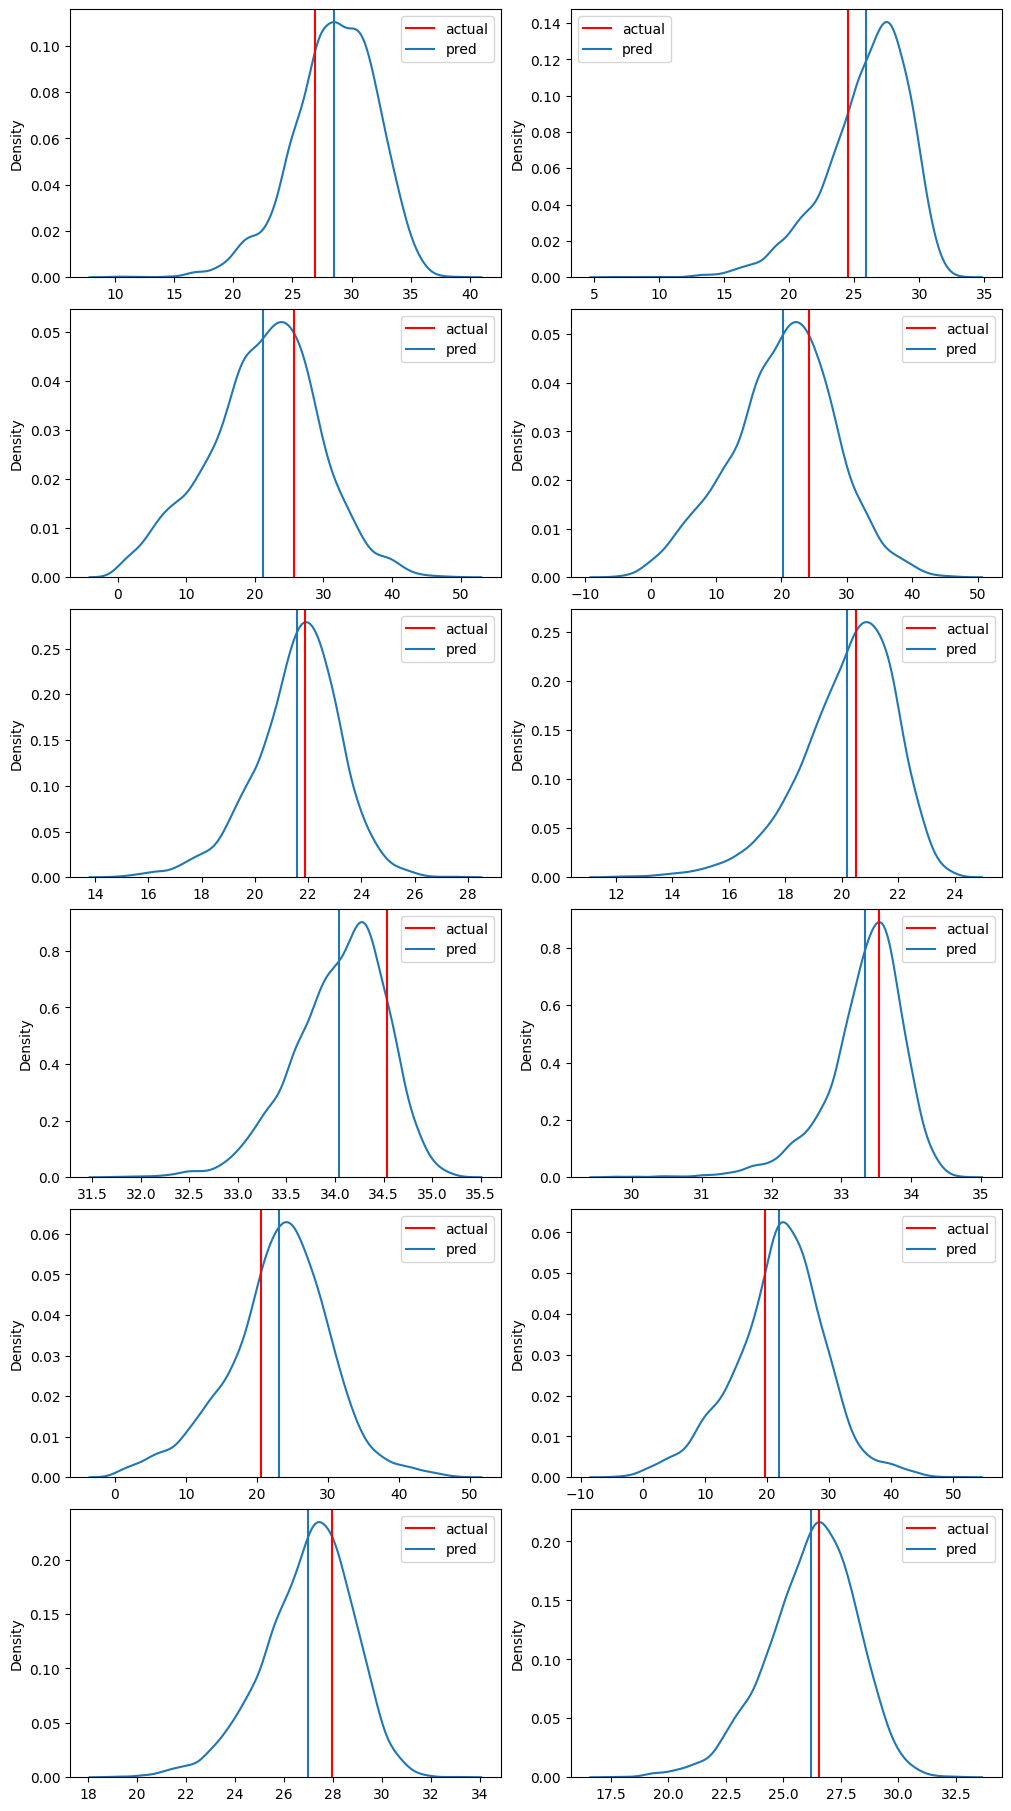

In [41]:
nrows, ncols = a_pred.shape[-3:-1]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sns.kdeplot(a_pred[:, i, j, 0], ax=ax)
        ax.axvline(a[draw_ind, sorted(subjects_ind), ..., 0][i, j], label="actual", color="red")
        ax.axvline(a_pred[:, i, j, 0].mean(), label="pred")
        ax.legend()

In [27]:
posterior_samples[site.a].mean(axis=0)[..., 0]

Array([[28.53095888, 25.93025566],
       [21.25455153, 20.25010621],
       [21.59865785, 20.18978784],
       [34.04627728, 33.33172324],
       [23.07338956, 21.99609373],
       [26.98734511, 26.20639873]], dtype=float64)

In [19]:
subjects_ind

[99, 70, 168, 24, 23, 77]

In [28]:
a[draw_ind, sorted(subjects_ind), ...][..., 0]

Array([[26.90701626, 24.54621103],
       [25.74598266, 24.18050929],
       [21.87488868, 20.52278842],
       [34.53506551, 33.54113176],
       [20.53937911, 19.62553228],
       [27.98386095, 26.55696959]], dtype=float64)

In [14]:
a = POSTERIOR_PREDICTIVE[site.a]


In [7]:
import gc

def _process(N_counter, draw_counter, repeat_counter, model):
    N = N_space[N_counter]
    draw_ind = draws_space[draw_counter]
    seed = repeats_space[repeat_counter]

    N_dir, draw_dir, seed_dir = f"N_{N}", f"draw_{draw_ind}", f"seed_{seed}"

    subjects_ind = \
        jax.random.choice(
            key=jax.random.PRNGKey(seed),
            a=np.arange(0, TOTAL_SUBJECTS, 1),
            shape=(N,),
            replace=False
        ) \
        .tolist()

    ind = PREDICTION_DF[MODEL.subject].isin(subjects_ind)
    df = PREDICTION_DF[ind].reset_index(drop=True).copy()
    df[MODEL.response] = OBS[draw_ind, ...][ind, ...]

    """ Build model """
    config = Config(toml_path=toml_path)
    config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, prefix, model.LINK, prefix_2, draw_dir, N_dir, seed_dir)
    model = model(config=config)

    """ Load data """
    df, _ = model.load(df=df)

    """ Fit """
    _, posterior_samples = model.run_inference(df=df)

    """ Predict """
    prediction_df = model.make_prediction_dataset(df=df, num_points=100)
    ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

    """ Plot """
    model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
    model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

    """ Save """
    dest = os.path.join(model.build_dir, "inference.pkl")
    with open(dest, "wb") as f:
        pickle.dump((posterior_samples, ), f)

    config, df, prediction_df, _,  = None, None, None, None
    model, posterior_samples = None, None
    ppd  = None

    del config, df, prediction_df, _, model, posterior_samples, ppd
    gc.collect()
    return


In [8]:
from joblib import Parallel, delayed


parallel = Parallel(n_jobs=-1)
parallel(
    delayed(_process)(N_counter, draw_counter, repeat_counter, model) \
    for draw_counter in range(5) \
    for N_counter in range(3) \
    for repeat_counter in range(10) \
    for model in [HierarchicalBayesianModel, NonHierarchicalBayesianModel]
)




Running chain 2:  85%|████████▌ | 1275/1500 [00:55<00:01, 137.40it/s]

Running chain 2:  80%|████████  | 1200/1500 [01:05<00:05, 53.37it/s]
2023-10-05 14:23:31,976 - hbmep.utils.utils - INFO - func:run_inference took: 53.48 sec
2023-10-05 14:23:31,983 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
Running chain 1:  25%|██▌       | 375/1500 [00:48<00:20, 54.12it/s]2023-10-05 14:23:32,021 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/hbm-vs-nhbm/non_hierarchical_bayesian/mu_a_delta_-0.1_sigma_a_delta_1/draw_761/N_2/seed_742/recruitment_curves.pdf
2023-10-05 14:23:32,032 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.83 sec
Running chain 0: 100%|██████████| 1500/1500 [00:29<00:00, 166.05it/s]2023-10-05 14:23:32,041 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...


Running chain 1:  85%|████████▌ | 1275/1500 [01:59<00:11, 19.82it/s]


Running chain 0:  15%|

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [9]:
from joblib import Parallel, delayed


parallel = Parallel(n_jobs=-1)
parallel(
    delayed(_process)(N_counter, draw_counter, repeat_counter, model) \
    for draw_counter in range(n_draws) \
    for N_counter in range(len(N_space)) \
    for repeat_counter in range(n_repeats) \
    for model in [HierarchicalBayesianModel, NonHierarchicalBayesianModel]
)


2023-10-05 14:33:11,224 - hbmep.config - INFO - Verifying configuration ...
2023-10-05 14:33:11,224 - hbmep.config - INFO - Success!
2023-10-05 14:33:11,225 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-10-05 14:33:11,225 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/hbm-vs-nhbm/hierarchical_bayesian/mu_a_delta_-0.1_sigma_a_delta_1/draw_1622/N_2/seed_1468
2023-10-05 14:33:11,225 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/hbm-vs-nhbm/hierarchical_bayesian/mu_a_delta_-0.1_sigma_a_delta_1/draw_1622/N_2/seed_1468
2023-10-05 14:33:11,225 - hbmep.dataset.core - INFO - Processing data ...
2023-10-05 14:33:11,226 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-10-05 14:33:11,226 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...
2023-10-05 14:33:11,230 - hbmep.con

Running chain 2:  70%|███████   | 1050/1500 [02:45<00:29, 15.07it/s]

Running chain 2:  80%|████████  | 1200/1500 [02:28<00:17, 16.94it/s]

Running chain 2:  50%|█████     | 750/1500 [02:09<00:37, 20.00it/s]

Running chain 1:  20%|██        | 300/1500 [00:29<00:38, 31.04it/s]


Running chain 3:  90%|█████████ | 1350/1500 [02:36<00:17,  8.80it/s]


Running chain 3:  55%|█████▌    | 825/1500 [01:02<00:25, 26.60it/s]2023-10-05 15:00:37,949 - hbmep.config - INFO - Verifying configuration ...
2023-10-05 15:00:37,964 - hbmep.config - INFO - Success!
2023-10-05 15:00:37,965 - hbmep.model.baseline - INFO - Initialized model with non_hierarchical_bayesian link
2023-10-05 15:00:37,965 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/hbm-vs-nhbm/non_hierarchical_bayesian/mu_a_delta_-0.1_sigma_a_delta_1/draw_1622/N_12/seed_1380
2023-10-05 15:00:37,965 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbme

KeyboardInterrupt: 